# Forecasting

Import libraries

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from pytagi import Normalizer
import pytagi.metric as metric
import copy
from pathlib import Path

Import components

In [11]:
from canari import (
    DataProcess,
    Model,
    plot_data,
    plot_prediction,
    plot_states,
)
from canari.component import LocalTrend, LstmNetwork, WhiteNoise

Read data

In [12]:
project_root = Path.cwd().resolve().parents[1]
data_file = str(project_root / "data" / "benchmark_data" / "test_4_data.csv")
df = pd.read_csv(data_file, skiprows=1, delimiter=",", header=None)
time = pd.to_datetime(df.iloc[:, 0])
df = df.iloc[:, 1:]
df.index = time
df.index.name = "time"
df.columns = ["crack opening", "water_level", "temp_min", "temp_max"]

Data preprocess

In [13]:
output_col = [0]
data_processor = DataProcess(
    data=df,
    time_covariates=["week_of_year"],
    train_split=0.4,
    validation_split=0.07,
    output_col=output_col,
)
train_data, validation_data, test_data, normalized_data = data_processor.get_splits()
data_processor.data.head()

,crack opening,water_level,temp_min,temp_max,week_of_year
time,,,,,
2010-11-07,6.595455,31.053637,-2.2,3.5,44.0
2010-11-14,6.523334,30.986666,-1.7,9.9,45.0
2010-11-21,6.430000,31.070000,-5.8,1.6,46.0
2010-11-28,6.360000,31.000000,-11.5,0.1,47.0
2010-12-05,6.210000,30.930000,-5.1,-1.1,48.0


Define model from components

In [5]:
local_trend = LocalTrend()
pattern = LstmNetwork(
        look_back_len=14,
        num_features=5, # number of data's columns + time covariates
        num_layer=1,
        num_hidden_unit=50,
        device="cpu",
        manual_seed=1,
    )
residual = WhiteNoise(std_error=0.04168)

model = Model(local_trend, pattern, residual)

Train model -- Objective: train LSTM neural network -- model.lstm_train()

In [6]:
model.auto_initialize_baseline_states(train_data["y"][0 : 52 * 3])
max_num_epoch = 50
states_optim = None
mu_validation_preds_optim = None
std_validation_preds_optim = None

for epoch in range(max_num_epoch):
    mu_validation_preds, std_validation_preds, states = model.lstm_train(
        train_data=train_data,
        validation_data=validation_data,
    )

    mu_validation_preds_unnorm = Normalizer.unstandardize(
        mu_validation_preds,
        data_processor.norm_const_mean[data_processor.output_col],
        data_processor.norm_const_std[data_processor.output_col],
    )

    std_validation_preds_unnorm = Normalizer.unstandardize_std(
        std_validation_preds,
        data_processor.norm_const_std[data_processor.output_col],
    )

    validation_obs = data_processor.get_data("validation").flatten()
    validation_log_lik = metric.log_likelihood(
        prediction=mu_validation_preds_unnorm,
        observation=validation_obs,
        std=std_validation_preds_unnorm,
    )

    model.early_stopping(evaluate_metric=-validation_log_lik, mode="min")

    if epoch == model.optimal_epoch:
        mu_validation_preds_optim = mu_validation_preds.copy()
        std_validation_preds_optim = std_validation_preds.copy()
        states_optim = copy.copy(states)
    if model.stop_training:
        break

Learning's curve

Optinal epoch       : 22
Validation -LL      :-1.3134


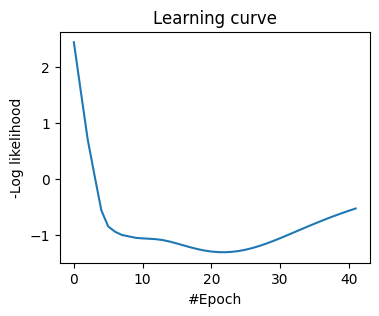

In [7]:
fig,ax = plt.subplots(figsize=(4,3))
plt.plot(model.early_stop_metric_history)
ax.set_ylabel("-Log likelihood")
ax.set_xlabel("#Epoch")
plt.title("Learning curve")
print(f"Optinal epoch       : {model.optimal_epoch}")
print(f"Validation -LL      :{model.early_stop_metric: 0.4f}")

Plot predictions

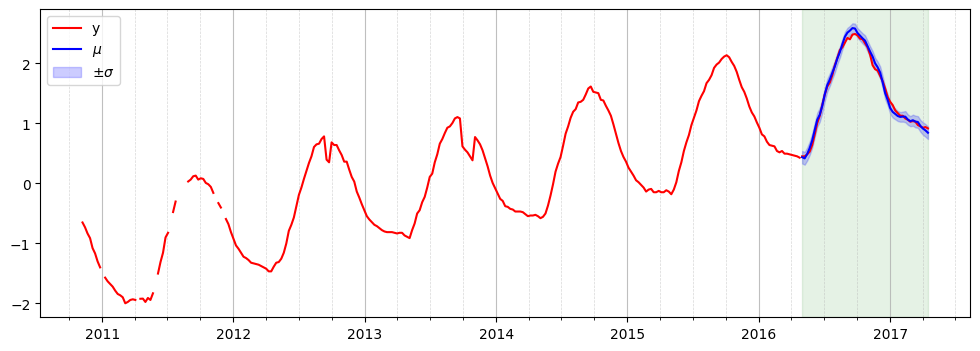

In [8]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_data(
    data_processor=data_processor,
    normalization=True,
    plot_test_data=False,
    plot_column=output_col,
    validation_label="y",
)
plot_prediction(
    data_processor=data_processor,
    mean_validation_pred=mu_validation_preds_optim,
    std_validation_pred=std_validation_preds_optim,
    validation_label=[r"$\mu$", f"$\pm\sigma$"],
)
plt.legend()
plt.show()

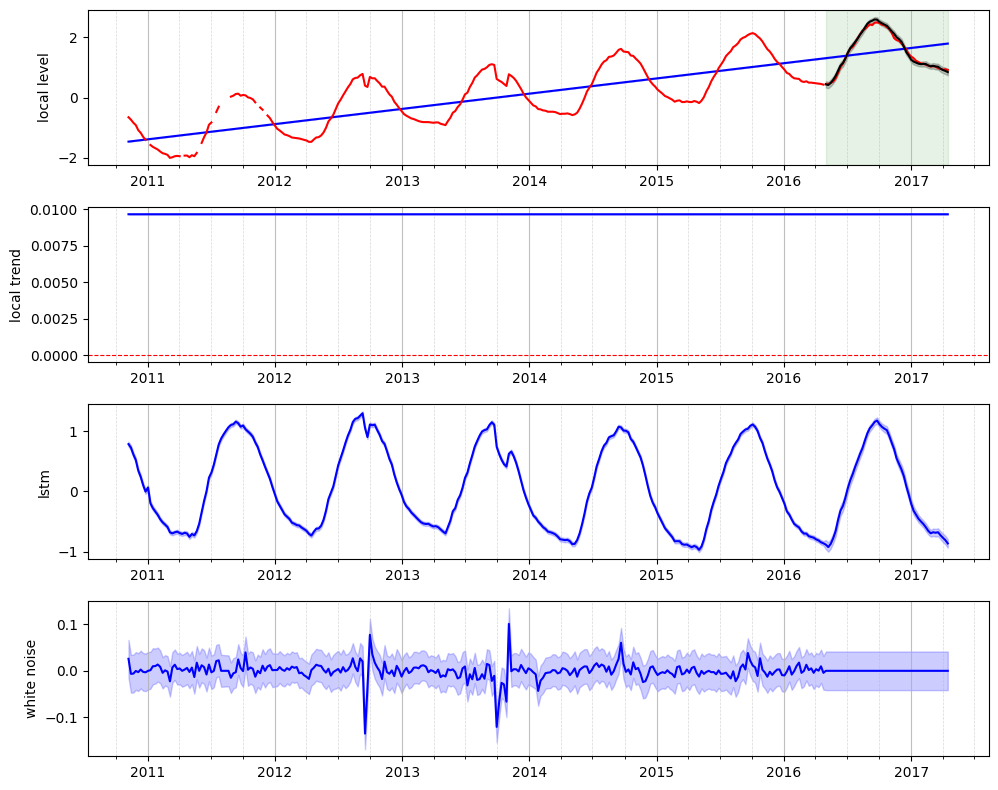

In [9]:
fig, ax =plot_states(data_processor=data_processor,normalization=True,
                     states=states)
plot_data(data_processor=data_processor,
        normalization=True,
        plot_test_data=False,
        sub_plot=ax[0])
plot_prediction(data_processor=data_processor,
                mean_validation_pred=mu_validation_preds_optim,
                std_validation_pred = std_validation_preds_optim,
                sub_plot=ax[0],
                color="k",
                )
plt.show()